# Penalty kicks 

This notebook analyzes the penalty kick data as a simultaneous move game of complete information. The data come from English premier league games in 2016-17. 

**Data source:** https://www.kaggle.com/mauryashubham/english-premier-league-penalty-dataset-201617

In [79]:
import pandas as pd 
import numpy as np 
import nashpy 
import matplotlib.pyplot as plt
import bimatrix

Global settings for pandas printing floats with two decimals. 

In [80]:
pd.options.display.float_format = '{:,.2f}'.format

In [81]:
def print_payoffs(U, A): 
    '''print_payoffs: Nicely formatted for a 2*2 game 
        INPUTS: 
            U1,U2: (matrices, dim=na1*na2) Payoffs 
            A1: (list of str, len=na1) List of actions of player 1
            A2: (list of str, len=na2) list of actions of player 2
        
        OUTPUT:
            tab: pandas dataframe, na1*na2 with payoff tuples 
    '''
    assert len(U) == 2, f'only implemented for 2-player games'
    assert len(A) == 2, f'only implemented for 2-player games'

    U1 = U[0]
    U2 = U[1]
    A1 = A[0]
    A2 = A[1]

    na1,na2 = U1.shape
    assert len(A1) == na1
    assert len(A2) == na2

    # "matrix" of tuples 
    X = [[(U1[r,c],U2[r,c]) for c in range(na2)] for r in range(na1)]

    # dataframe version 
    tab = pd.DataFrame(X, columns=A2, index=A1)
    
    return tab

In [82]:
dat = pd.read_csv('penalty_data.csv', encoding='latin')

In [83]:
dat['Date'] = pd.to_datetime(dat.Date)

In [84]:
print(f'Penalty kicks from games: ')
dat.Date.dt.year.value_counts()

Penalty kicks from games: 


2016    63
2017    43
Name: Date, dtype: int64

There are missing observations in the data. We can only analyzes instances where all variables are observed. 

In [85]:
I = (dat.Kick_Direction.notnull()) & (dat.Keeper_Direction.notnull()) & (dat.Scored.notnull())
print(f'Deleting {(I==False).sum()} rows => N = {I.sum()} penalty kicks in final data.')
dat = dat[I].copy()

Deleting 3 rows => N = 103 penalty kicks in final data.


**Action distribution:** How frequently do each player choose each action? 

In [86]:
dat.Kick_Direction.value_counts(normalize=True)

L   0.46
R   0.38
C   0.17
Name: Kick_Direction, dtype: float64

In [87]:
dat.Keeper_Direction.value_counts(normalize=True)

R   0.50
L   0.44
C   0.06
Name: Keeper_Direction, dtype: float64

**Joint distribution** Plotted together by cross-tabulating, we get: 

In [88]:
pd.crosstab(dat.Keeper_Direction, dat.Kick_Direction)

Kick_Direction,C,L,R
Keeper_Direction,,,
C,1,2,3
L,7,20,18
R,9,25,18


The key outcome: whether a goal was scored or not

In [89]:
dat['goal'] = dat.Scored == 'Scored' #penalty kick resulted in a score

# Reduced matrix, discarding `C`

In [90]:
I = (dat.Kick_Direction != "C") & (dat.Keeper_Direction != "C")

In [91]:
shares = dat.loc[I].groupby(['Kick_Direction', 'Keeper_Direction']).goal.mean().unstack().round(2)
shares

Keeper_Direction,L,R
Kick_Direction,,
L,0.65,0.88
R,0.83,0.56


In [92]:
# extracting the names of the actions 
A1 = shares.index.values
A2 = shares.columns.values

print(A1)
print(A2)

['L' 'R']
['L' 'R']


In [117]:
U1 = shares.values.round(2)
U2 = (1-U1).round(2)
U2

array([[0.35, 0.12],
       [0.17, 0.44]])

***... continue work from here...***

In [135]:
G = nashpy.Game(U1,U2)
G

Bi matrix game with payoff matrices:

Row player:
[[0.65 0.88]
 [0.83 0.56]]

Column player:
[[0.35 0.12]
 [0.17 0.44]]

In [136]:
G = nashpy.Game(U1,U2)

In [137]:
sol = G.support_enumeration()
sol = list(sol)
sol
#Ssh. i lige vægten.

[(array([0.54, 0.46]), array([0.64, 0.36]))]

Plotting results for 1 equilibria


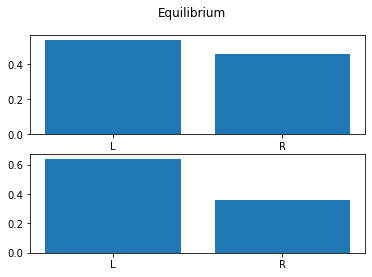

In [138]:
print(f'Plotting results for {len(sol)} equilibria')
for i,eq in enumerate(sol): 
    fig,axs  = plt.subplots(2)
    fig.suptitle(f'Equilibrium')
    axs[0].bar(A1, eq[0], label=f'player 1')
    axs[1].bar(A2, eq[1], label=f'player 2')

In [139]:
bimatrix.print_payoffs(U1,U2)

,0,1
0,"(0.65, 0.35)","(0.88, 0.12)"
1,"(0.83, 0.17)","(0.56, 0.44)"


In [140]:
#Laver grid a ssh. fra 0-100 af steps 1
p = np.linspace(0,1,100)

##Fra hæftet er p = q og pp = p.
pp = np.hstack([p, 1-p]).reshape(2,100) 
# top row is Pr(first action), bottom row is Pr(second action)

pp[:,:3]

array([[0.        , 0.01010101, 0.02020202],
       [1.        , 0.98989899, 0.97979798]])

In [141]:
#Forventede værdier
Eu1 = U1 @ pp
Eu1[:, :3]

array([[0.88      , 0.87767677, 0.87535354],
       [0.56      , 0.56272727, 0.56545455]])

In [142]:
I = np.isclose(Eu1[0,:], Eu1[1,:])
if I.any():
    idx = np.where(I)
    print(idx,Eu1[:, idx].flatten())
else: 
    print('no match')
#No match betyder der er rene strategier.

no match


In [143]:
def BR_1(Eu1):
    '''Best response in binary actions 
    '''
    x,G = Eu1.shape
    assert x == 2, f'Eu must be 2*G'
    
    br = np.empty((G,))
    
    I = Eu1[0,:] > Eu1[1,:]
    br[I] = 1 # the 0th action gives the highest payoff, so Pr(0th action) = 100% 
    I = Eu1[0,:] < Eu1[1,:]
    br[I] = 0 # the last action gives the highest payoff, so Pr(first action) = 0%
    I = Eu1[0,:] == Eu1[1,:]
    br[I] = 0.5 # actually, the best response is *any* probability in [0;1]. But for plotting purposes, we use 50%
    
    return br

In [144]:
#Best response for skytte
Eu1 = U1 @ pp
br1 = BR_1(Eu1)
#br1 = Eu1.argmax()
#br1

In [145]:
#Best response for målmand
Eu2 = pp.T @ U2
br2 = BR_1(Eu2.T)
#br2 = Eu2.argmax()
#br1

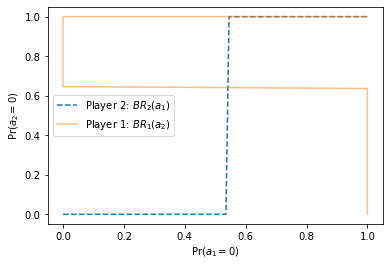

In [146]:
fig,ax = plt.subplots()
ax.plot(p, br2, '--', label=f'Player 2: $BR_2(a_1)$');
ax.plot(np.append(br1, 1.0), np.append(p, 1.0), '-', label=f'Player 1: $BR_1(a_2)$', alpha=0.5);
ax.legend();
ax.set_xlabel('$\Pr(a_1 = 0)$');
ax.set_ylabel('$\Pr(a_2 = 0)$');

# Full payoff matrix

Display overall means of the key outcome (whether a goal was scored). 

In [253]:
pd.options.display.float_format = '{:,.2f}'.format

In [266]:
A = ['L','C','R'] # sequence of the actions 
goals = dat.groupby(['Kick_Direction', 'Keeper_Direction']).goal.mean().unstack().loc[A, A]
goals.round(2)

Keeper_Direction,L,C,R
Kick_Direction,,,
L,0.65,1.00,0.88
C,1.00,0.00,0.89
R,0.83,1.00,0.56


In [267]:
O1 = goals.values
O1.round(2)
O2 = 1-O1
A1 = ['L', 'C','R']
A2 = A1
print(O2.round(3))

[[0.35  0.    0.12 ]
 [0.    1.    0.111]
 [0.167 0.    0.444]]


In [268]:
print_payoffs([O1.round(2), O2.round(2)], [A1, A2])

,L,C,R
L,"(0.65, 0.35)","(1.0, 0.0)","(0.88, 0.12)"
C,"(1.0, 0.0)","(0.0, 1.0)","(0.89, 0.11)"
R,"(0.83, 0.17)","(1.0, 0.0)","(0.56, 0.44)"


In [269]:
P = nashpy.Game(O1,O2)
Payoff = bimatrix.print_payoffs(O1.round(2),O2.round(2))
Payoff = Payoff.round(2)
Payoff

,0,1,2
0,"(0.65, 0.35)","(1.0, 0.0)","(0.88, 0.12)"
1,"(1.0, 0.0)","(0.0, 1.0)","(0.89, 0.11)"
2,"(0.83, 0.17)","(1.0, 0.0)","(0.56, 0.44)"


In [258]:
sol = P.support_enumeration()
sol = list(sol)
sol 

[(array([0.47562426, 0.2175981 , 0.30677765]),
  array([0.52080856, 0.18489893, 0.29429251]))]

In [259]:
Eu1 = U1@a1 # matrix * vector = vector 
pd.DataFrame(zip(A[0], Eu1), columns=['action', 'expected utility']) 

,action,expected utility
0,L,"[0.7674673008323425, 0.30414982164090365, 0.45..."


Plotting results for 1 equilibria


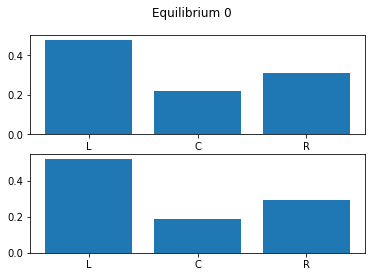

In [260]:
print(f'Plotting results for {len(sol)} equilibria')
for i,eq in enumerate(sol): 
    fig,axs  = plt.subplots(2)
    fig.suptitle(f'Equilibrium {i}')
    axs[0].bar(A1, eq[0], label=f'player 1')
    axs[1].bar(A2, eq[1], label=f'player 2')

***... continue from here...***

# A different dataset

The following dataset comes from a different source: The French and Italian elite leagues from 1997-2000, totalling 459 observations of penalty kicks. The raw micro data is not available, but Tables 3 and 4 provide us what we need to conduct the same analysis as above. 

* **Source:** Chiappori, Levitt, and Groseclose (2003): "Testing Mixed-Strategy Equilibria When Players Are Heterogeneous: The Case of Penalty Kicks in Soccer", *American Economic Review*, vol 91, no. 4. 

In [261]:
# frequency of kicks by (kicker, goalie) actions
tab = pd.DataFrame(np.array([
    [117, 48, 95],
    [4, 3, 4], 
    [85, 28, 75]
]).T, index=A, columns=A)
tab.index.name = 'Kicker' 
tab.columns.name = 'Goalie'
tab

Goalie,L,C,R
Kicker,,,
L,117,4,85
C,48,3,28
R,95,4,75


In [263]:
# the fraction of shots of each type that results in a goal
goals1 = pd.DataFrame(np.array([
    [63.2, 81.2, 89.5], 
    [100.0, 0., 100.0], 
    [94.1, 89.3, 44.0]
]).T / 100.0, index=A, columns=A) # we transpose to have the Kicker be player 1 
goals1.index.name = 'Kicker' 
goals1.columns.name = 'Goalie' 
goals1

Goalie,L,C,R
Kicker,,,
L,0.63,1.00,0.94
C,0.81,0.00,0.89
R,0.90,1.00,0.44


Continue from here. 

In [247]:
S1 = goals1.values
S1.round(2)
S2 = 1-S1
A1 = ['L', 'C','R']
A2 = A1
print(S2.round(3))

[[0.368 0.    0.059]
 [0.188 1.    0.107]
 [0.105 0.    0.56 ]]


In [248]:
print_payoffs([S1.round(2), S2.round(2)], [A1, A2])

,L,C,R
L,"(0.63, 0.37)","(1.0, 0.0)","(0.94, 0.06)"
C,"(0.81, 0.19)","(0.0, 1.0)","(0.89, 0.11)"
R,"(0.9, 0.1)","(1.0, 0.0)","(0.44, 0.56)"


In [265]:
S = nashpy.Game(S1,S2)
Payoff = bimatrix.print_payoffs(S1.round(2),S2.round(2))
Payoff = Payoff.round(2)
Payoff

,0,1,2
0,"(0.63, 0.37)","(1.0, 0.0)","(0.94, 0.06)"
1,"(0.81, 0.19)","(0.0, 1.0)","(0.89, 0.11)"
2,"(0.9, 0.1)","(1.0, 0.0)","(0.44, 0.56)"


In [250]:
sol = S.support_enumeration()
sol = list(sol)
sol 

[(array([0.42891382, 0.23751836, 0.33356782]),
  array([0.5953258 , 0.09215786, 0.31251634]))]

Plotting results for 1 equilibria


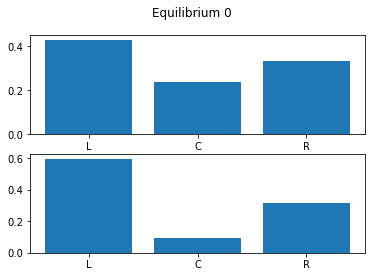

In [251]:
print(f'Plotting results for {len(sol)} equilibria')
for i,eq in enumerate(sol): 
    fig,axs  = plt.subplots(2)
    fig.suptitle(f'Equilibrium {i}')
    axs[0].bar(A1, eq[0], label=f'player 1')
    axs[1].bar(A2, eq[1], label=f'player 2')